In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nih_chest_xrays_data_path = kagglehub.dataset_download('nih-chest-xrays/data')

print('Data source import complete.')


🔍 Sedang mencari 1000 gambar di dataset...
✅ Berhasil memuat 1000 gambar.
⏳ Sedang menghitung kompresi... (Mungkin butuh 1-2 menit)


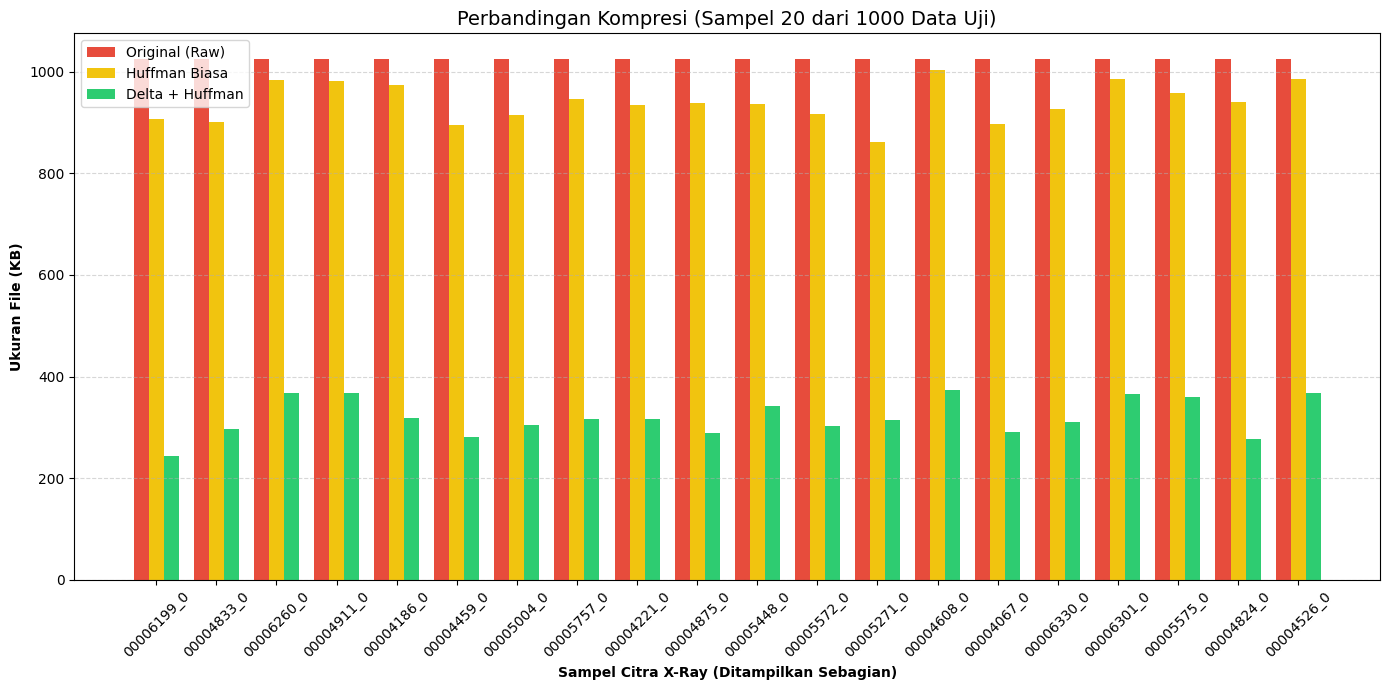

In [ ]:
import os
import cv2
import numpy as np
import heapq
from collections import Counter
import matplotlib.pyplot as plt

# ==========================================
# KONFIGURASI JUMLAH DATA
# ==========================================
TOTAL_DATA_PROCESSED = 1000  # Total gambar yang dihitung (untuk tabel/statistik)
DISPLAY_ON_GRAPH = 20        # Jumlah gambar yang ditampilkan di grafik (biar rapi)

# ==========================================
# BAGIAN 1: ENGINE HUFFMAN (TETAP)
# ==========================================
class HuffmanNode:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def get_huffman_size_bits(data):
    if len(data) == 0: return 0
    frequency = Counter(data)
    heap = [HuffmanNode(char, freq) for char, freq in frequency.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    root = heap[0] if heap else None

    def get_depths(node, depth=0, depths={}):
        if node:
            if node.char is not None: depths[node.char] = depth
            get_depths(node.left, depth + 1, depths)
            get_depths(node.right, depth + 1, depths)
        return depths

    depths = get_depths(root)
    return sum(count * depths[char] for char, count in frequency.items())

# ==========================================
# BAGIAN 2: CARI FILE (Sapu Jagat)
# ==========================================
print(f"🔍 Sedang mencari {TOTAL_DATA_PROCESSED} gambar di dataset...")

image_paths = []
for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if file.endswith('.png'):
            image_paths.append(os.path.join(root, file))
            if len(image_paths) >= TOTAL_DATA_PROCESSED:
                break
    if len(image_paths) >= TOTAL_DATA_PROCESSED:
        break

print(f"✅ Berhasil memuat {len(image_paths)} gambar.")
print("⏳ Sedang menghitung kompresi... (Mungkin butuh 1-2 menit)")

# ==========================================
# BAGIAN 3: PROSES SEMUA DATA
# ==========================================
results = {'names': [], 'raw': [], 'huffman': [], 'delta': []}

for path in image_paths:
    filename = os.path.basename(path)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None: continue

    flat_pixels = img.flatten()

    # Hitung 3 Metode
    bits_raw = len(flat_pixels) * 8
    bits_huff = get_huffman_size_bits(flat_pixels)
    # Delta Encoding (Solusi Utama)
    delta_pixels = np.abs(np.diff(flat_pixels, prepend=0))
    bits_delta = get_huffman_size_bits(delta_pixels)

    results['names'].append(filename[:10]) # Potong nama biar pendek
    results['raw'].append(bits_raw / 8192)       # KB
    results['huffman'].append(bits_huff / 8192)
    results['delta'].append(bits_delta / 8192)

# ==========================================
# BAGIAN 4: VISUALISASI (Cuma Sampel Biar Rapi)
# ==========================================

# Ambil cuplikan data saja untuk grafik
subset_names = results['names'][:DISPLAY_ON_GRAPH]
subset_raw = results['raw'][:DISPLAY_ON_GRAPH]
subset_huff = results['huffman'][:DISPLAY_ON_GRAPH]
subset_delta = results['delta'][:DISPLAY_ON_GRAPH]

x = np.arange(len(subset_names))
width = 0.25

plt.figure(figsize=(14, 7)) # Ukuran kanvas lebar

plt.bar(x - width, subset_raw, width, label='Original (Raw)', color='#e74c3c')
plt.bar(x, subset_huff, width, label='Huffman Biasa', color='#f1c40f')
plt.bar(x + width, subset_delta, width, label='Delta + Huffman', color='#2ecc71')

plt.xlabel('Sampel Citra X-Ray (Ditampilkan Sebagian)', fontweight='bold')
plt.ylabel('Ukuran File (KB)', fontweight='bold')
plt.title(f'Perbandingan Kompresi (Sampel {DISPLAY_ON_GRAPH} dari {len(image_paths)} Data Uji)', fontsize=14)
plt.xticks(x, subset_names, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ==========================================
# BAGIAN 5: KESIMPULAN STATISTIK TOTAL
# ==========================================
avg_raw = sum(results['raw']) / len(results['raw'])
avg_huff = sum(results['huffman']) / len(results['huffman'])
avg_delta = sum(results['delta']) / len(results['delta'])
avg_saving = ((avg_huff - avg_delta) / avg_huff) * 100



In [ ]:
# --- KODE HITUNG PERSENTASE UNTUK TABEL 1 ---

# 1. Hitung Rata-rata Ukuran (KB)
avg_raw = sum(results['raw']) / len(results['raw'])
avg_huff = sum(results['huffman']) / len(results['huffman'])
avg_delta = sum(results['delta']) / len(results['delta'])

# 2. Hitung Persentase Penghematan (Vs Raw)
# Rumus: ((Awal - Akhir) / Awal) * 100
percent_huff = ((avg_raw - avg_huff) / avg_raw) * 100
percent_delta = ((avg_raw - avg_delta) / avg_raw) * 100

# 3. Tampilkan Output Rapi
print("="*50)
print("DATA FINAL UNTUK TABEL 1 (SIAP COPY)")
print("="*50)

print(f"| Metode                 | Rata-rata (KB) | % Hemat    |")
print(f"|------------------------|----------------|------------|")
print(f"| Original (Raw)         | {avg_raw:<14.2f} | 0.00%      |")
print(f"| Huffman Biasa          | {avg_huff:<14.2f} | {percent_huff:.2f}%     |")
print(f"| Delta + Huffman        | {avg_delta:<14.2f} | {percent_delta:.2f}%     |")
print("="*50)
print("\n" + "="*50)
print(f"HASIL AKHIR DARI {len(image_paths)} GAMBAR")
print("="*50)
print(f"Rata-rata Ukuran Raw       : {avg_raw:.2f} KB")
print(f"Rata-rata Huffman Biasa    : {avg_huff:.2f} KB")
print(f"Rata-rata Delta + Huffman  : {avg_delta:.2f} KB")
print("-" * 50)
print(f"✅ Rata-rata Penghematan (vs Huffman Biasa): {avg_saving:.2f}%")
print("="*50)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


DATA FINAL UNTUK TABEL 1 (SIAP COPY)
| Metode                 | Rata-rata (KB) | % Hemat    |
|------------------------|----------------|------------|
| Original (Raw)         | 1024.00        | 0.00%      |
| Huffman Biasa          | 939.85         | 8.22%     |
| Delta + Huffman        | 309.23         | 69.80%     |

HASIL AKHIR DARI 1000 GAMBAR
Rata-rata Ukuran Raw       : 1024.00 KB
Rata-rata Huffman Biasa    : 939.85 KB
Rata-rata Delta + Huffman  : 309.23 KB
--------------------------------------------------
✅ Rata-rata Penghematan (vs Huffman Biasa): 67.10%


🔍 Sedang mencari file untuk uji validitas Lossless...
✅ Menggunakan sampel: 00006199_010.png

[1] Data Asli:
    - Jumlah Pixel: 1048576
    - 5 Pixel Pertama: [1 1 1 1 1]

[2] Setelah Delta Encoding (Disimpan):
    - Jumlah Data: 1048576
    - 5 Data Pertama: [1 0 0 0 0] (Isinya angka kecil/selisih)

[3] Setelah Dekompresi (Dipulihkan):
    - Jumlah Pixel: 1048576
    - 5 Pixel Pertama: [1 1 1 1 1]

HASIL VERIFIKASI INTEGRITAS DATA
✅ STATUS: SUKSES (LOSSLESS)
   Ukuran file kembali sama persis.
   Nilai setiap pixel kembali sama persis.
   Tidak ada informasi medis yang hilang.


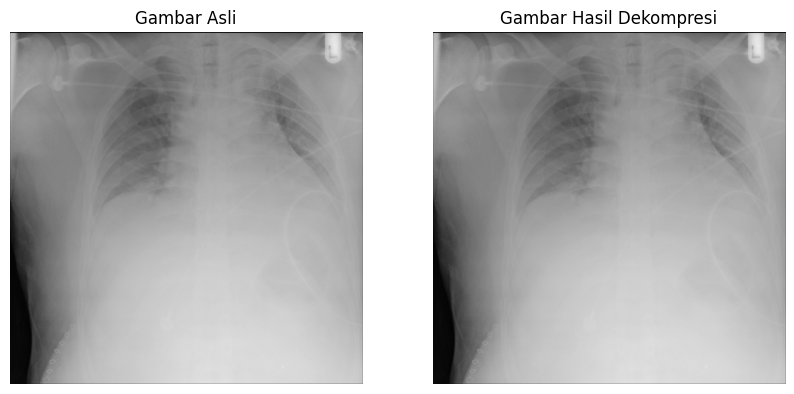

In [ ]:
# ==========================================
# FUNGSI UJI COBA (ENCODE -> DECODE)
# ==========================================

print("🔍 Sedang mencari file untuk uji validitas Lossless...")

# Cari 1 file gambar saja sebagai sampel uji
sample_path = None
for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if file.endswith('.png'):
            sample_path = os.path.join(root, file)
            break
    if sample_path: break

if not sample_path:
    print("❌ Error: Tidak ada gambar ditemukan.")
else:
    print(f"✅ Menggunakan sampel: {os.path.basename(sample_path)}")

    # 1. BACA GAMBAR ASLI (ORIGINAL)
    # Gunakan int16 agar aman saat menghitung selisih (minus)
    img_original = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    pixels_original = img_original.flatten().astype(np.int16)

    print(f"\n[1] Data Asli:")
    print(f"    - Jumlah Pixel: {len(pixels_original)}")
    print(f"    - 5 Pixel Pertama: {pixels_original[:5]}")

    # 2. PROSES KOMPRESI (ENCODE: DELTA)
    # Rumus: Pixel[i] - Pixel[i-1]
    # prepend=0 artinya pixel pertama dikurangi 0
    pixels_encoded = np.diff(pixels_original, prepend=0)

    print(f"\n[2] Setelah Delta Encoding (Disimpan):")
    print(f"    - Jumlah Data: {len(pixels_encoded)}")
    print(f"    - 5 Data Pertama: {pixels_encoded[:5]} (Isinya angka kecil/selisih)")

    # 3. PROSES DEKOMPRESI (DECODE: INVERSE DELTA)
    # Rumus: Dijumlahkan secara kumulatif (Cumulative Sum)
    pixels_decoded = np.cumsum(pixels_encoded).astype(np.int16)

    print(f"\n[3] Setelah Dekompresi (Dipulihkan):")
    print(f"    - Jumlah Pixel: {len(pixels_decoded)}")
    print(f"    - 5 Pixel Pertama: {pixels_decoded[:5]}")

    # 4. VERIFIKASI (PEMBUKTIAN)
    # Cek apakah Array Asli == Array Hasil Dekompresi
    is_same_size = len(pixels_original) == len(pixels_decoded)
    is_content_identical = np.array_equal(pixels_original, pixels_decoded)

    print("\n" + "="*40)
    print("HASIL VERIFIKASI INTEGRITAS DATA")
    print("="*40)

    if is_same_size and is_content_identical:
        print("✅ STATUS: SUKSES (LOSSLESS)")
        print("   Ukuran file kembali sama persis.")
        print("   Nilai setiap pixel kembali sama persis.")
        print("   Tidak ada informasi medis yang hilang.")
    else:
        print("❌ STATUS: GAGAL (CORRUPT)")
        print("   Data berubah saat dikembalikan!")

    # Visualisasi Bukti
    plt.figure(figsize=(10, 5))

    # Gambar Asli
    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title("Gambar Asli")
    plt.axis('off')

    # Gambar Hasil Restore
    plt.subplot(1, 2, 2)
    # Kembalikan bentuk array 1 baris ke bentuk kotak (2D)
    img_restored = pixels_decoded.reshape(img_original.shape)
    plt.imshow(img_restored, cmap='gray')
    plt.title("Gambar Hasil Dekompresi")
    plt.axis('off')

    plt.show()